In [1]:
data_path = '../datasets/AICity_data/train/S03/c010/'

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from PIL import Image
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *
from lobster import Subsense

In [16]:
def drawRectangleOnImage(img, boxes, color=(0, 255, 0)):
    for box in boxes:
        img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 3)
    return img

In [17]:
# def getBoxesFromMaskV2(mask):
#     output = cv2.connectedComponentsWithStats(np.uint8(mask), 8, cv2.CV_32S)
#     (numLabels, labels, boxes, centroids) = output
#     detectedElems = []
#     for box in boxes[1:]: #First box is always the background
#         if box[4] > 500: #Try to do a better estimation of the minimunm size
#             b = [box[0], box[1], box[2], box[3]]
#             detectedElems.append(b)

#     return detectedElems

## GIFs

In [26]:
def generate_gif(videoPath, fgbg, videoName='video'):
    fig, ax = plt.subplots()
    plt.axis('off')
    
    vidcap = cv2.VideoCapture(videoPath)
    ims = []
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))

    for frame in tqdm(range(1,num_frames//4)):
        for i in range(4):
            _, image = vidcap.read()
        fgmask = fgbg.apply(image)
        
        im = ax.imshow(fgmask, animated=True)
        ims.append([im])
    # break

    ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=10000)
    ani.save(videoName + ".gif", writer=animation.PillowWriter(fps=24))

100%|██████████| 534/534 [00:58<00:00,  9.11it/s]


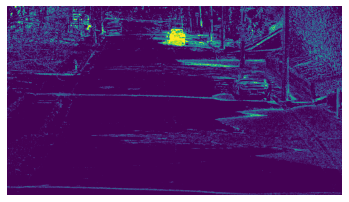

In [29]:
generate_gif(data_path + 'vdo.avi', knn, 'KNN')

## Background estimation

In [48]:
def closing(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, element)

def opening(mask, kernel_w=3, kernel_h=3):
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_w, kernel_h))
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, element)

def gaussianBlur(mask, kernel_w=3, kernel_h=3):
    return cv2.GaussianBlur(mask, (kernel_w,kernel_h),0)


def getBoxesFromMask2(mask):
    # output = cv2.connectedComponentsWithStats(np.uint8(mask), 8, cv2.CV_32S)
    # (numLabels, labels, boxes, centroids) = output
    counts, hier = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    detectedElems = []
    for cont in counts: #First box is always the background
        x,y,w,h = cv2.boundingRect(cont)
        if w*h > 700: #Try to do a better estimation of the minimunm size
            b = VehicleDetection(0, -1, float(x), float(y), float(w), float(h), float(-1))
            detectedElems.append(b)

    return detectedElems

def remove_background3(videoPath, ROIpath, fgbg, alpha=4, sigma=2):
    roi = cv2.imread(ROIpath, cv2.IMREAD_GRAYSCALE)
    
    vidcap = cv2.VideoCapture(videoPath)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
#     num_frames = 500
    detections = {}
    for frame in tqdm(range(num_frames)):
        _, image = vidcap.read()
        if frame >= num_frames // 4:
            fgmask = fgbg.apply(image)
            fgmask[fgmask==127]=0
#             img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#             img_mask = np.zeros(img_gray.shape, dtype = np.uint8)
#             img_mask[abs(img_gray - means) >= alpha * (stds + sigma)] = 255

            roi_applied = cv2.bitwise_and(fgmask, roi)
            cleaned = opening(roi_applied, 5, 5) #initial removal of small noise
            cleaned = closing(cleaned, 50, 20) #vertical filling of areas [SWITCH TO HORIZONTAL?]
            cleaned = closing(cleaned, 20, 50) #vertical filling of areas [SWITCH TO HORIZONTAL?]
            cleaned = opening(cleaned, 7, 7) #initial removal of small noise

            roi_applied = cv2.bitwise_and(cleaned, roi)

#             cv2.imwrite(f'./masks/mask_{frame}.png', roi_applied)

            detections[str(frame)] = getBoxesFromMask2(roi_applied)
            roi_applied = cv2.cvtColor(roi_applied,cv2.COLOR_GRAY2RGB)
            for b in detections[str(frame)]:
                tl = (int(b.xtl), int(b.ytl))
                br = (int(b.xbr), int(b.ybr))
                color = (255,0,0)
                roi_applied = cv2.rectangle(roi_applied, tl, br, color, 2)
#             cv2.imwrite(f'./masks_bb/mask_{frame}.png', roi_applied)
            
    return detections

In [49]:
### GT without parked cars
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')
gt_notParked = {}
for frame, objs in gt_detect.items():
    obj_notParked = []
    for ob in objs:
        if not ob.parked:
            obj_notParked.append(ob)
    if len(obj_notParked) > 0:
        gt_notParked[frame] = obj_notParked

In [50]:
mog = cv2.bgsegm.createBackgroundSubtractorMOG() 
mog2 = cv2.createBackgroundSubtractorMOG2()
knn = cv2.createBackgroundSubtractorKNN()
gmg = cv2.bgsegm.createBackgroundSubtractorGMG()

### MOG

100%|██████████| 2141/2141 [02:41<00:00, 13.26it/s]


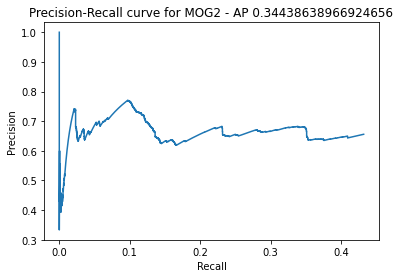

In [31]:
MOG_detections = remove_background3(data_path + 'vdo.avi', data_path + 'roi.jpg', mog, 4.7, 2)
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, MOG_detections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for MOG - AP {ap}')

### MOG2

100%|██████████| 2141/2141 [03:22<00:00, 10.56it/s]


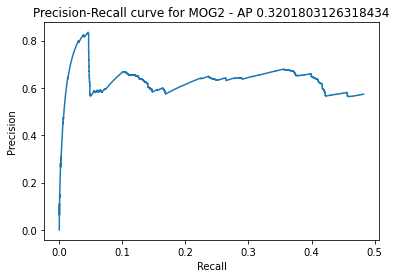

In [51]:
MOG2_detections = remove_background3(data_path + 'vdo.avi', data_path + 'roi.jpg', mog2, 4.7, 2)
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, MOG2_detections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for MOG2 - AP {ap}')

### KNN

100%|██████████| 2141/2141 [02:38<00:00, 13.51it/s]


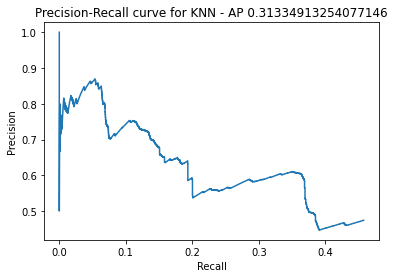

In [36]:
KNN_detections = remove_background3(data_path + 'vdo.avi', data_path + 'roi.jpg', knn, 4.7, 2)
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, KNN_detections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for KNN - AP {ap}')

### GMG

100%|██████████| 2141/2141 [08:57<00:00,  3.98it/s]


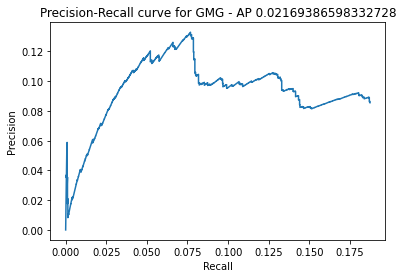

In [45]:
GMG_detections = remove_background3(data_path + 'vdo.avi', data_path + 'roi.jpg', gmg, 4.7, 2)
rec, prec, ap, tp_gauss, IoU_tp, IoU = voc_eval(gt_notParked, GMG_detections, 0.5, False)
plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for GMG - AP {ap}')